In [96]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

import os
from mpl_toolkits.basemap import Basemap

In [2]:
with open('models/model.p', 'rb') as file:
    model_up = pickle.load(file)
with open('data/locations.p', 'rb') as file:
    locations = pickle.load(file)
with open('models/vec.p', 'rb') as file:
    vec = pickle.load(file)
with open('archive/predictor.p', 'rb') as file:
    pred = pickle.load(file)
with open('archive/text.p', 'rb') as file:
    text = pickle.load(file)

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.2 when

In [19]:
with open('data/fires.p', 'rb') as file:
    fires = pickle.load(file)
with open('train/test_mask.p', 'rb') as file:
    test_mask = pickle.load(file)

In [38]:
pred['location'] = pred['address'].apply(lambda x: locations[x])

In [39]:
train_mask = (pred['status_date'] - pd.to_datetime('2003-01-01')).apply(lambda x: x.days) <= 5478

In [40]:
train_mask = train_mask.values

In [41]:
pred['has_existing_stories'] = (~pred['existing_stories'].isnull()).astype(int)
pred['existing_stories'] = pred['existing_stories'].fillna(0)

In [244]:
X_text = vec.transform(text)

In [248]:
pred['prediction'] = model.predict_proba(pred, X_text)

In [254]:
y = (fires[:,1] > 0).astype(int)

In [9]:
x_axis, y_axis = np.array([x for x,y in pred.location]), np.array([y for x,y in pred.location])

In [101]:
sample_idx = np.random.choice(test_mask.sum(), 1000, replace = False)

In [11]:
mask = test_mask

In [53]:
temp_mask = (pred['status_date'].apply(lambda x: x.year) < 2015).values

In [79]:
mask = (pred['status_date'].apply(lambda x: x.year) < 2016).values
mask = mask & ~temp_mask

In [17]:
pred['prediction'].iloc[sample_idx].shape

(1000,)

In [163]:
sample_idx = np.random.choice(mask.sum(), 1000)

In [93]:
with open('data/predictor.p', 'wb') as file:
    pickle.dump(pred, file)

In [87]:
def coloring(number):
    if number > .6:
        return 'red'
    elif number > .3:
        return 'orange'
    else:
        return 'green'
f = np.vectorize(coloring)

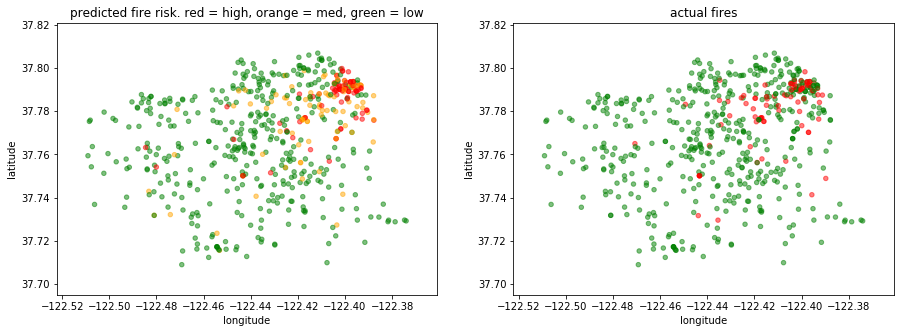

In [65]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].set_title('predicted fire risk. red = high, orange = med, green = low')
axs[0].set_xlabel('longitude')
axs[0].set_ylabel('latitude')
axs[0].scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(pred['prediction'][mask].iloc[sample_idx]), alpha = .5, s = 20)

axs[1].set_title('actual fires')
axs[1].set_xlabel('longitude')
axs[1].set_ylabel('latitude')
axs[1].scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(y[mask][sample_idx]), alpha = .5, s = 20)

In [67]:
fig.savefig('results/pred_actual.png')

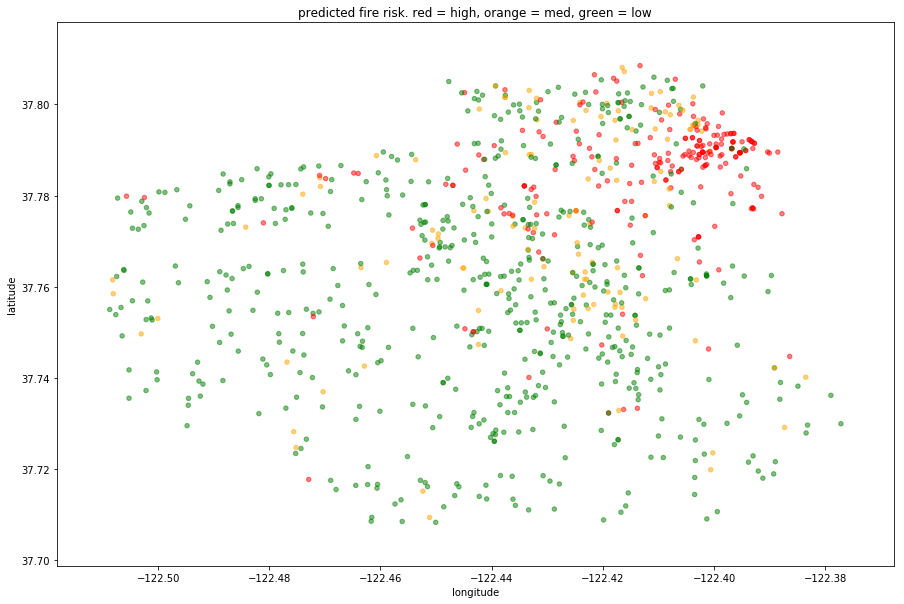

In [25]:
plt.figure(figsize = (15,10))
plt.title('predicted fire risk. red = high, orange = med, green = low')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(pred['prediction'][mask].iloc[sample_idx]), alpha = .5, s = 20)

In [33]:
model_up.threshold

0.358

In [85]:
np.vectorize(lambda x: bool(x))(x_axis)

array([ True,  True,  True, ...,  True,  True,  True])

In [114]:
ll_lon = (x_axis[np.vectorize(lambda x: bool(x))(x_axis)]).min()-.02
ll_lat = (y_axis[np.vectorize(lambda x: bool(x))(x_axis)]).min()-.02
ur_lon = (x_axis[np.vectorize(lambda x: bool(x))(x_axis)]).max()+.02
ur_lat = (y_axis[np.vectorize(lambda x: bool(x))(x_axis)]).max()+.01

In [147]:
np.nanmean(y_axis.astype(float))

37.76704965788464

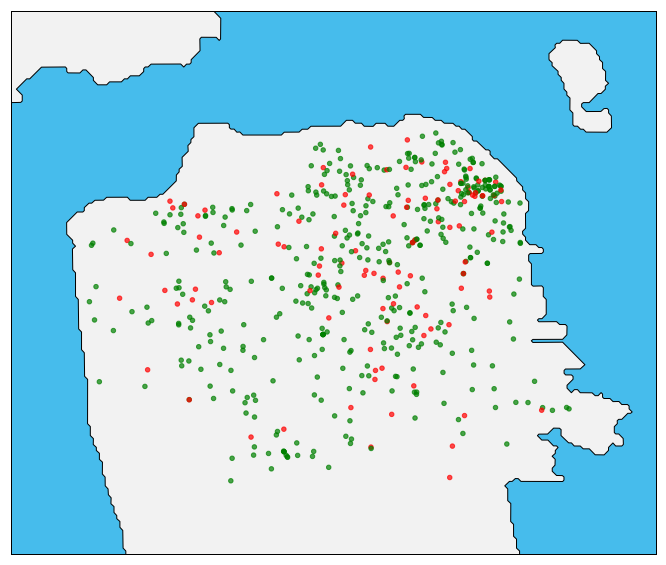

In [134]:
plt.figure(figsize = (15,10))
m = Basemap(llcrnrlon = ll_lon, llcrnrlat = ll_lat, urcrnrlon = ur_lon, urcrnrlat = ur_lat, resolution = 'f')
m.drawcoastlines()
# plt.title('actual fires')
# plt.xlabel('longitude')
# plt.ylabel('latitude')
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(y[sample_idx]), alpha = .7, s = 20, zorder = 2)
plt.savefig('results/actual.png')

In [189]:
with open('results/word_clusters.p', 'rb') as file:
    word_clusters = pickle.load(file)
with open('results/ratios_up.p', 'rb') as file:
    ratios_up = pickle.load(file)

In [202]:
y[pred['topic'] == 'topic 0'].mean().round(4)

0.0286

In [204]:
for i in range(6):
    s = 'topic ' + str(i)
    print('Fire risk rate for topic', str(i), 'is', str(y[pred['topic'] == s].mean().round(4)))

Fire risk rate for topic 0 is 0.0286
Fire risk rate for topic 1 is 0.0614
Fire risk rate for topic 2 is 0.1363
Fire risk rate for topic 3 is 0.3572
Fire risk rate for topic 4 is 0.1146
Fire risk rate for topic 5 is 0.2175


In [206]:
word_clusters[6]

array([['family', 'dwelling', 'reroofing', 'reroofingnan', 'nan', 're',
        'roofing', 'renew', 'report', 'nannan', 'reroofingnannan'],
       ['and', 'replace', 'in', 'new', 'window', 'kitchen', 'remodel',
        'to', 'of', 'bathroom', 'at'],
       ['apartment', 'reroofing', 'soft', 'story', 'retrofit', 'per',
        'unit', 'appendix', 'chapter', 'nan', 'reroofingnan'],
       ['final', 'work', 'inspection', 'for', 'obtain', 'complete',
        'renew', 'approved', 'under', 'all', 'pa'],
       ['office', 'floor', 'fire', 'sprinkler', 'ref', 'maher',
        'relocate', 'for', 'new', 'ti', 'el'],
       ['retail', 'sale', 'food', 'beverage', 'hndlng', 'to', 'sign',
        'fire', 'system', 'new', 'install']], dtype='<U15')

In [255]:
roc_auc_score(y[mask], pred['prediction'][mask])

0.812273738558321

In [258]:
f1_score(y[mask], (pred['prediction'][mask]>.358).astype(int))

0.4171261199172984

In [251]:
1 - y[mask].mean()

0.8795593470813461

In [209]:
with open('models/model.p', 'rb') as file:
    model = pickle.load(file)

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning:

Trying to unpickle estimator LogisticRegression from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning:

Trying to unpickle estimator DecisionTreeRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning:

Trying to unpickle estimator GradientBoostingClassifier from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning:

Trying to unpickle estimator TfidfTransformer from version 0.20.2 when using version 0.20.3. This might lead

In [235]:
top_idx = model.m1.coef_[0].argsort()[-1:-11:-1]

In [236]:
vocab_idx = {value:key for (key, value) in vec.vocabulary_.items()}

In [237]:
for i in top_idx:
    print(vocab_idx[i], model.m1.coef_[0][i])

artifial 2.1174634724873163
withvinyl 1.982151274794083


KeyError: 37204

In [240]:
model.m1.coef_[0].shape

(40662,)

In [70]:
plotly.__version__

'3.5.0'

In [71]:
import plotly.plotly as py
import plotly.graph_objs as go

In [186]:
trace0 = go.Scattermapbox(
    lon = x_axis[mask][sample_idx],
    lat = y_axis[mask][sample_idx],
    mode = 'markers', 
    text = pred['address'].iloc[sample_idx],
    marker = dict(
        color = f(y[mask][sample_idx]),
        size = 14,
        opacity = .6
    )
)
layout = go.Layout(
    autosize = True,
    hovermode = 'closest', 
    mapbox = go.layout.Mapbox(
        center = go.layout.mapbox.Center(
            lat = 37.76,
            lon = -122.44
        ),
        pitch = 0,
        zoom = 12
    )
)
data = [trace0]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'truth', auto_open = True)

In [261]:
trace0 = go.Scattermapbox(
    lon = x_axis[mask][sample_idx],
    lat = y_axis[mask][sample_idx],
    mode = 'markers', 
    text = pred['address'].iloc[sample_idx],
    marker = dict(
        color = f(preds), 
        size = 14,
        opacity = .6
    )
)
layout = go.Layout(
    autosize = True,
    hovermode = 'closest', 
    mapbox = go.layout.Mapbox(
        center = go.layout.mapbox.Center(
            lat = 37.76,
            lon = -122.44
        ),
        pitch = 0,
        zoom = 12
    )
)
data = [trace0]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'prediction', auto_open = False)

In [330]:
vocab_idx[model.m1.coef_[0].argsort()[4]]

'boston'

In [331]:
(pred[pred['description'].astype(str).apply(lambda x: 'BOSTON' in x)]['fires_after'] > 0).mean()

0.14705882352941177

In [301]:

for i in model.m1.coef_[0].argsort()[-1:-31:-1]:
    words.append((vocab_idx[i], model.m1.coef_[0][i]))
    print(vocab_idx[i], model.m1.coef_[0][i])

bart 4.036372792252763
mall 3.6514255023884012
kiosk 3.1423896503206388
hospital 3.0881040677286893
laminate 2.8047492218016625
damage 2.7762205415787373
aurora 2.6992370803055903
tower 2.626917286392459
generator 2.472786993663446
hotel 2.4414559631432526
apt 2.4375732040843747
market 2.2817305471180758
fitness 2.178032620730866
vendor 2.1166341979883967
suite 2.0496917276804436
fargo 2.0355388314298035
corridor 2.0184674198255066
buildout 2.001573954169106
fireplacenan 1.9876892032933917
trash 1.95893423340907
laminet 1.8933052626525853
sale 1.8890136414978382
live 1.8634941145787964
evacuation 1.851362709027323
pharmacy 1.8500893560381313
zam 1.8438361230510782
complex 1.8353320232404926
earthwork 1.816605349378749
tank 1.8128054935277425
calculation 1.8068433643724826


In [299]:
pred[pred['description'].astype(str).apply(lambda x: 'AURORA' in x)]['description'].values

array(['REMOVE 5 ALUMINUM WINDOWS & REPLACE IN KIND WITH AURORA 6000 "BEST" TILT DOUBEL HUNG WINDOWS                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     nan',
       'REPLACE EXISTING ALUMINUM SINGLE HUNG WITH VINYL DOUBLE HUNG BY AURORA MANUFACTURING 6000 BEST TILT',
       'REPLACE EXIST ALUM SINGLE HUNG WITH VINYL DOUBLE HUNG BY AURORA MFG 6000 BEST TILT APPROVED BY MARK',
       'REMOVE 6 EXTG ALUMINUM SINGLE GLAZED WNDW. REPLACE WI

In [322]:
(pred[pred['description'].astype(str).apply(lambda x: 'SAME' in x)]['fires_after'] > 0).mean()

0.10755222281735405

In [287]:
pred['fires_after'] = fires[:,1]

In [314]:
words[:10]

[('bart', 4.036372792252763),
 ('mall', 3.6514255023884012),
 ('kiosk', 3.1423896503206388),
 ('hospital', 3.0881040677286893),
 ('laminate', 2.8047492218016625),
 ('damage', 2.7762205415787373),
 ('aurora', 2.6992370803055903),
 ('tower', 2.626917286392459),
 ('generator', 2.472786993663446),
 ('hotel', 2.4414559631432526)]

In [318]:
print('| Word\t| Fire Risk')
print('|:------|:--------')
for word, coef in words[:15]:
    print('|', word, '\t|', (pred[pred['description'].astype(str).apply(lambda x: word.upper() in x)]['fires_after'] > 0).mean().round(4))

| Word	| Fire Risk
|:------|:--------
| bart 	| 0.8118
| mall 	| 0.1865
| kiosk 	| 0.5946
| hospital 	| 0.44
| laminate 	| 0.2715
| damage 	| 0.0741
| aurora 	| 0.9286
| tower 	| 0.3728
| generator 	| 0.4038
| hotel 	| 0.3575
| bart 	| 0.8118
| mall 	| 0.1865
| kiosk 	| 0.5946
| hospital 	| 0.44
| laminate 	| 0.2715
